In [1]:
import numpy as np
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)  # for nicer-looking plots
import jax.numpy as jnp
import jax
import optax
import scipy

In [2]:
!pip install -U dm-haiku
import haiku as hk
rng_seq = hk.PRNGSequence(np.random.randint(2**32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Part 1: Human Behavior

In this Colab, we will put to practive what we've learned in today's lecture:
* **We will first train an RL agent to perform a task, using policy evaluation and policy improvement.**
* **After that, we will fit an RL model to a real human dataset, and analyze (fake) fMRI data!**

To get started, let's first load our dataset to get it out of the way. Execute the following cell to load the dataset from gitbub into this Colab.

In [19]:
# # Option 1
# human_data = pd.read_csv("./bahrami_100.csv")

# Option 2 (in case option 1 doesn't work)
from google.colab import files
import io
uploaded = files.upload()
human_data = pd.read_csv(io.BytesIO(uploaded['bahrami_100.csv']))

human_data

Saving bahrami_100.csv to bahrami_100 (5).csv


,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036
...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784


First, let's understand our task. We are working with a "4-armed bandit task". The figure below depicts what is happening on each trial of this task from participants' perspective:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/TaskOverview.png?raw=1" width=1000></center>

## Exercise 1: Understand the task (*5 minutes*)

* Find a partner (turn to your neighbor)
* Together, understand the task design:
  * First, let the person sitting left explain the first two stages ("Participant choice" and "Chosen stimulus") to the person sitting right. (*2 minutes*)
  * Then, let the person sitting right explain the last two stages ("Reward" and "Inter-trial interval") to the person sitting left. (*1 minute*)
  * Lastly, talk about any questions you still have about this task. (*2 minutes*)

## Solution 1

Now, expand the cells below to see the solution.

Participants perform the task on a computer. On each trial of the task, participants see four items on the screen (which we sometimes call "bandits"). In the "participant choice" stage, participants have 4 seconds to pick one of the bandits, using four keys on their keyboard ("d", "f", "j", and "k"). Once the participant has made a choice, all bandit except the selected one disappear, and only the selected one stays on the screen for 400 miliseconds (0.4 seconds). Then, the reward is displayed: Participants can win between 1-100 points on each trial, depending on which bandit they choose. The reward stays on the screen for 800 miliseconds, then a fixation cross appears in the center of the screen for half a second. After the fixation cross, participants enter the next trial, which is structured in the same way.

In this task, participants do a total of 150 trials, and thereby learn which bandits tend to give more points than others, so they can maximize the points they win. Let's take a look at the dataset!

In [20]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036
...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784


## Exercise 2: Dataset basic numbers (*5 minutes*)

With your partner or by yourself, answer the following questions:
* How many participants are in the dataset?
* How many trials did each participant perform?
* What are the minimum and maximum points to be gained per trial?

Use the starter code below to find the answers:

In [21]:
# Number of participants (we are giving you the solution here already)
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
# ============== FILL IN THE BLANKS BELOW ================
n_trials = ...

# Number of bandits
# ============== FILL IN THE BLANKS BELOW ================
n_bandits = ...

# Min and max points
# ============== FILL IN THE BLANKS BELOW ================
min_points = ...
max_points = ...

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: Ellipsis
Number of bandits (available actions): Ellipsis
Minimum number of points in this game: Ellipsis. Maximum number: Ellipsis


In [22]:
#@title Click to show Solution 2
# Number of participants
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
n_trials = len(np.unique(human_data['trial_id']))

# Number of bandits
n_bandits = len(np.unique(human_data['action'])) - 1  # action '-1' indicates missed trial

# Min and max points
min_points, max_points = min(human_data['reward']), max(human_data['reward'])

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: 150
Number of bandits (available actions): 4
Minimum number of points in this game: 0.0. Maximum number: 92.0


Let's understand this dataset.

Each row contains the data for one trial of one participant. (Saving data in this way is called the "long format".)

* The column `participant_id` tells us which participant the data is coming from. Each participant has an ID between 1-100
* The column `action` tell us which bandit the participant chose. Bandit are numbered between 0-3
* The column `reward` tells us how many points the partipants won on this trial, by selected the bandit they selected
* `response_time` tells us how long the participant took to select the bandit
* `reward_actionX` tells us what the reward would have been for each action, had the participant chosen it on this trial. This is the same for all participants

## Exercise 3: Visualize available points (*10 minutes*)
Now, let's vizualize how many points each bandit gives on each trial of the task. (You will need the columns `reward_actionX` for this exercise.)
* Plot trials (from 0-150) on the x-axis
* And plot the reward each bandit would have given (from 1-100) on the y-axis
* Select a different color for each bandit to distinguish them

Use the starter code below:

In [23]:
# Let's first melt the dataset so that every row contains the reward ("value") of just one bandit ("variable")
long_data = pd.melt(human_data, id_vars=['participant_id', 'trial_id', 'action', 'reward', 'response_time', 'missed', 'BOLD'])
long_data = long_data.replace({'reward_action{}'.format(i): 'Bandit {}'.format(i) for i in range(n_bandits)})
long_data

,participant_id,trial_id,action,reward,response_time,missed,BOLD,variable,value
0,0,0,0.0,84.0,1104.0,False,-0.431696,Bandit 0,84
1,0,1,1.0,90.0,1076.0,False,-1.838983,Bandit 0,90
2,0,2,2.0,53.0,612.0,False,-0.586366,Bandit 0,80
3,0,3,3.0,24.0,742.0,False,-1.954475,Bandit 0,87
4,0,4,1.0,92.0,927.0,False,0.171036,Bandit 0,86
...,...,...,...,...,...,...,...,...,...
59995,99,145,2.0,62.0,679.0,False,-0.611651,Bandit 3,48
59996,99,146,2.0,61.0,686.0,False,-2.034087,Bandit 3,57
59997,99,147,2.0,70.0,600.0,False,0.105932,Bandit 3,43
59998,99,148,2.0,60.0,641.0,False,2.235784,Bandit 3,59


In [24]:
# Now, let's create the plot
# ============== FILL IN THE BLANKS BELOW ================
gg_points_over_trials = (gg.ggplot(long_data, gg.aes(x='...', y='...', color='...'))
 + gg.geom_point()
 + gg.labs(x='...', y='...', color='...')
 + gg.coord_cartesian(ylim=(0, 100))
)

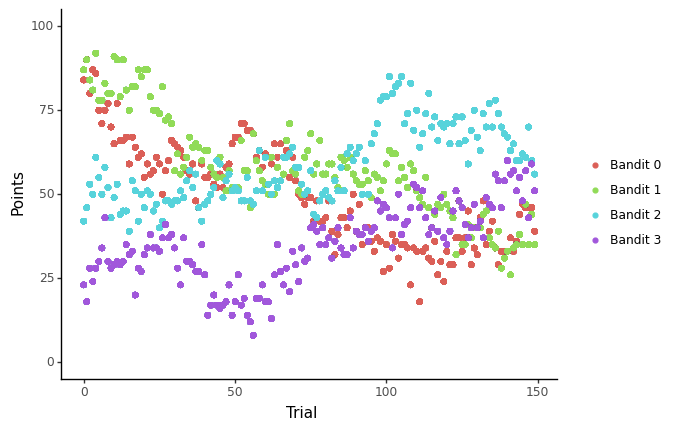

<ggplot: (8757418804276)>

In [25]:
#@title Click to show Solution 3
gg_points_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable'))
 + gg.geom_point()
 + gg.labs(x='Trial', y='Points', color='')
 + gg.coord_cartesian(ylim=(0, 100))
)
gg_points_over_trials

## Exercise 4: Visualize human behavior (*10 minutes*)

Now, let's vizualize which bandits participants chose on each trial of the task. (You will need the column `action` for this exercise.)
* Plot trials (from 0-150) on the x-axis
* And plot the proportion of participants who chose each bandit (from 0-100\%) on the y-axis
* Select a different color for each bandit to distinguish them

Use the starter code below:

In [26]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036
...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784


In [27]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
human_data[action_cols] = jax.nn.one_hot(jnp.array(human_data['action']), n_bandits)
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD,action_0,action_1,action_2,action_3
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696,1.0,0.0,0.0,0.0
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983,0.0,1.0,0.0,0.0
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366,0.0,0.0,1.0,0.0
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475,0.0,0.0,0.0,1.0
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651,0.0,0.0,1.0,0.0
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087,0.0,0.0,1.0,0.0
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932,0.0,0.0,1.0,0.0
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784,0.0,0.0,1.0,0.0


In [28]:
# Now, let's melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_data = pd.melt(human_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_data

,participant_id,trial_id,variable,value
0,0,0,action_0,1.0
1,0,1,action_0,0.0
2,0,2,action_0,0.0
3,0,3,action_0,0.0
4,0,4,action_0,0.0
...,...,...,...,...
59995,99,145,action_3,0.0
59996,99,146,action_3,0.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


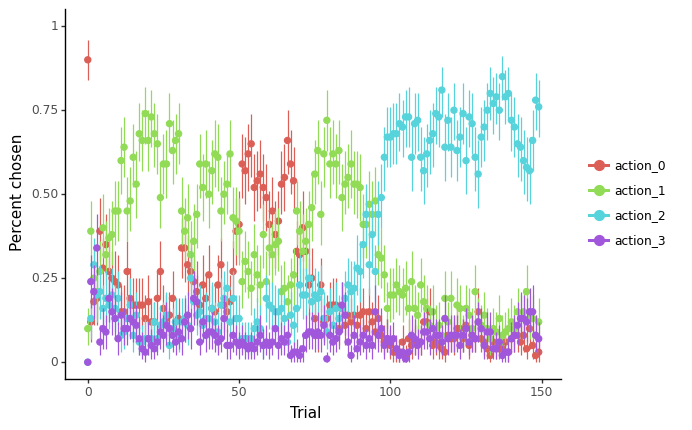

<ggplot: (8757419487398)>

In [29]:
#@title Click to show Solution 4
gg_actions_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
)
gg_actions_over_trials

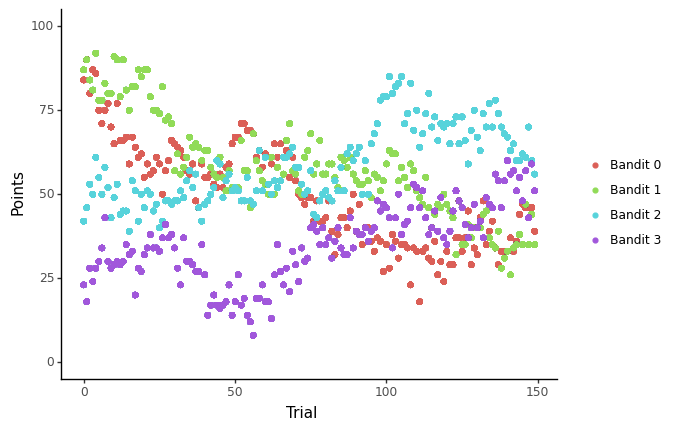

<ggplot: (8757418804276)>

In [30]:
gg_points_over_trials

## Exercise 5: Interpret findings (*5 minutes*)

Compare the two plots you have made, showing the available points (Exercise 3) and showing human choices (Exercise 4).
* What do you notice?
* How do you explain the patterns you are seeing?

## Solution 5

Expand the cell below to see the solution.

The two plots look quite similar: When one color line is high in one plot, it also tends to be high in the other.

The explanation is that participants in this task learn to choose the bandits that give the most points: Whenever a line is high in the first plot, there are lots of points to be earned, and this drives up the line in the second plot, which shows that participants tend to choose the corresponding action.

# Part 2: Train an RL agent to solve the same task

Now that we know how humans are doing the task, let's see if we can train an AI agent to do it!

We heard about a few different approaches for how to do this in class, mainly:
* Rescorla Wagner
* TD learning
* Q-learning
* SARSA

## Exercise 1: Which method? (*5 minutes*)

With your partner or by yourself, think about which of these four methods would be best for our case.

(Hint: Look back at the task description and figures we made, and try to imagine what a value function and a policy would look like in this case. To chose one approach for training, consider if we need just a value function or also a policy; and whether we want to learn on-policy or off-policy.)

## Solution 1
Click below to expand.

We are interested in training an agent to *do* something, aka to *act*; therefore, we want to use an algorithm that learns an *action policy*, on top of a value function. This rules out Rescorla Wagner and TD learning, which only learn a value function (e.g., to predict Pavlovian responses), but no action policy.

We next have the choice between off-policy (Q-learning) and on-policy learning (SARSA): Whereas Q-learning calculates values based on the best action that *could have been chosen*, SARSA calculates values based on the action that *was actually chosen*. Because our environemnt is not stationary (aka, the rewards for the bandits are changing over time), the on-policy method works better here. Furthermore, SARSA usually uses a *stochastic* policy (aka, it selects actions with some random noise). This will also help us here because we need "exploration" (aka, picking random actions once in a while) to discover new actions in a changing environment.

## Exercise 2: Write the value function (*10 minutes*)

In [31]:
class RlAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value
    self._alpha = rl_parameters['alpha']
    self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [32]:
rl_parameters = {'alpha': 0.3, 'beta': 3.}
agent = RlAgent(n_actions=2, rl_parameters=rl_parameters)
action_1h = np.array([[1, 0], [0, 1]])  # one-hot representation of action "0"
reward = 1  # reward for action "0" is 1
batch_size = 2  # we simulate 1 agent
n_trials_sim = 4  # we simulate 4 trials

agent_values = agent.initial_values(batch_size)  # we initialize t
print(f'Initial action values {agent_values}')

for trial in range(n_trials_sim):
  print(f'\nTrial {trial}')
  print(f'Action {action_1h}')
  print(f'Reward {reward}')
  agent_values = agent.update_values(agent_values, action_1h, reward)
  print(f'New action values {agent_values}')

action_probs = agent.calculate_action_probs(agent_values)
print(action_probs)
action = agent.choose_action(action_probs)
print(action)

Initial action values [[0.5 0.5]
 [0.5 0.5]]

Trial 0
Action [[1 0]
 [0 1]]
Reward 1
New action values [[0.65 0.5 ]
 [0.5  0.65]]

Trial 1
Action [[1 0]
 [0 1]]
Reward 1
New action values [[0.755 0.5  ]
 [0.5   0.755]]

Trial 2
Action [[1 0]
 [0 1]]
Reward 1
New action values [[0.82850003 0.5       ]
 [0.5        0.82850003]]

Trial 3
Action [[1 0]
 [0 1]]
Reward 1
New action values [[0.87995005 0.5       ]
 [0.5        0.87995005]]
[[0.75765216 0.24234788]
 [0.24234788 0.75765216]]
[0 1]


In [33]:
reward_schedule = human_data[['reward_action{}'.format(i) for i in range(n_bandits)]].values / 100
reward_schedule

array([[0.84, 0.87, 0.42, 0.23],
       [0.9 , 0.9 , 0.46, 0.18],
       [0.8 , 0.84, 0.53, 0.28],
       ...,
       [0.46, 0.35, 0.7 , 0.43],
       [0.46, 0.44, 0.6 , 0.59],
       [0.39, 0.35, 0.56, 0.51]])

In [34]:
agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)
agent_values = agent.initial_values(batch_size)
print(f'Action values {agent_values}')

for trial in range(n_trials):

  print(f'\nTrial {trial}')

  action_probs = agent.calculate_action_probs(agent_values)
  print(f'Action probabilities {action_probs}')

  action = agent.choose_action(action_probs)
  action_1h = jax.nn.one_hot(action, n_bandits)
  print(f'Chosen action {action_1h}')

  reward = reward_schedule[trial, action]
  print(f'Obtained reward {reward}')

  agent_values = agent.update_values(agent_values, action_1h, reward)
  print(f'Action values {agent_values}')

Action values [[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Chosen action [[0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Obtained reward [0.42 0.42]
Action values [[0.5        0.5        0.47599998 0.5       ]
 [0.5        0.5        0.47599998 0.5       ]]

Trial 1
Action probabilities [[0.25441855 0.25441855 0.23674433 0.25441855]
 [0.25441855 0.25441855 0.23674433 0.25441855]]
Chosen action [[0. 1. 0. 0.]
 [1. 0. 0. 0.]]
Obtained reward [0.9 0.9]
Action values [[0.5        0.62       0.47599998 0.5       ]
 [0.62       0.5        0.47599998 0.5       ]]

Trial 2
Action probabilities [[0.22915491 0.3284545  0.21323574 0.22915491]
 [0.3284545  0.22915491 0.21323574 0.22915491]]
Chosen action [[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Obtained reward [0.8 0.8]
Action values [[0.59000003 0.62       0.47599998 0.5       ]
 [0.674      0.5        0.47599998 0.5       ]]

Trial 3
Action probabilities [[0.28027678 0.30667162 0.19909409 0.21395752]
 

## Exercise X: Simulate agents

Simulate 50 agents on this task and plot them in the same way as the human dataset.

In [36]:
def simulate_rl_agents(agent, batch_size, n_trials, n_bandits, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = agent.choose_action(action_probs)
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = reward_schedule[trial, action]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

In [37]:
n_rl_agents = 2
n_rl_agent_trials = 3

agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)
simulation = simulate_rl_agents(agent, n_rl_agents, n_rl_agent_trials, n_bandits, verbose=True)
simulation['all_actions'], simulation['all_rewards']

Initial action values [[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Chosen action [[0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Obtained reward [0.42 0.87]
New action values [[0.5        0.5        0.47599998 0.5       ]
 [0.5        0.611      0.5        0.5       ]]

Trial 1
Action probabilities [[0.25441855 0.25441855 0.23674433 0.25441855]
 [0.22752367 0.31742904 0.22752367 0.22752367]]
Chosen action [[0. 1. 0. 0.]
 [0. 0. 1. 0.]]
Obtained reward [0.9  0.46]
New action values [[0.5        0.62       0.47599998 0.5       ]
 [0.5        0.611      0.488      0.5       ]]

Trial 2
Action probabilities [[0.22915491 0.3284545  0.21323574 0.22915491]
 [0.22936897 0.32000348 0.22125855 0.22936897]]
Chosen action [[0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Obtained reward [0.53 0.53]
New action values [[0.5    0.62   0.4922 0.5   ]
 [0.5    0.611  0.5006 0.5   ]]


(array([[2, 1],
        [1, 2],
        [2, 2]], dtype=int32),
 array([[0.42, 0.87],
        [0.9 , 0.46],
        [0.53, 0.53]]))

In [39]:
n_rl_agents = 10
n_rl_agent_trials = 150

simulation = simulate_rl_agents(agent, n_rl_agents, n_rl_agent_trials, n_bandits)

In [40]:
actions_long = np.array(simulation['all_actions']).T.flatten()
rewards_long = np.array(simulation['all_rewards']).T.flatten()
rl_agent_data = pd.DataFrame({'action': actions_long, 'reward': rewards_long})
rl_agent_data['trial_id'] = np.tile(np.arange(n_rl_agent_trials), n_rl_agents)
rl_agent_data['participant_id'] = np.repeat(np.arange(n_rl_agents), n_rl_agent_trials)
rl_agent_data

,action,reward,trial_id,participant_id
0,2,0.42,0,0
1,1,0.90,1,0
2,0,0.80,2,0
3,1,0.81,3,0
4,2,0.61,4,0
...,...,...,...,...
2995,0,0.47,145,19
2996,1,0.47,146,19
2997,0,0.46,147,19
2998,2,0.60,148,19


In [41]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
rl_agent_data[action_cols] = jax.nn.one_hot(jnp.array(rl_agent_data['action']), n_bandits)
rl_agent_data

,action,reward,trial_id,participant_id,action_0,action_1,action_2,action_3
0,2,0.42,0,0,0.0,0.0,1.0,0.0
1,1,0.90,1,0,0.0,1.0,0.0,0.0
2,0,0.80,2,0,1.0,0.0,0.0,0.0
3,1,0.81,3,0,0.0,1.0,0.0,0.0
4,2,0.61,4,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2995,0,0.47,145,19,1.0,0.0,0.0,0.0
2996,1,0.47,146,19,0.0,1.0,0.0,0.0
2997,0,0.46,147,19,1.0,0.0,0.0,0.0
2998,2,0.60,148,19,0.0,0.0,1.0,0.0


In [42]:
# Now, let's melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_rl_agent_data = pd.melt(rl_agent_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_rl_agent_data

,participant_id,trial_id,variable,value
0,0,0,action_0,0.0
1,0,1,action_0,0.0
2,0,2,action_0,1.0
3,0,3,action_0,0.0
4,0,4,action_0,0.0
...,...,...,...,...
11995,19,145,action_3,0.0
11996,19,146,action_3,0.0
11997,19,147,action_3,0.0
11998,19,148,action_3,0.0


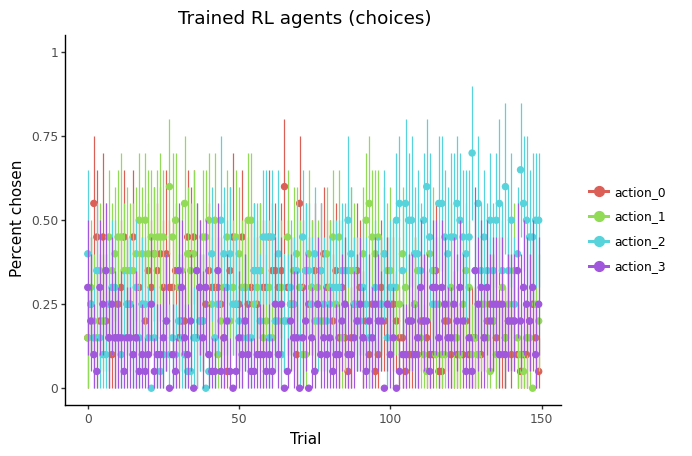

<ggplot: (8757391559167)>

In [43]:
#@title Click to show Solution 4
gg_actions_over_trials_rl_agents = (gg.ggplot(long_rl_agent_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
 + gg.labs(title='Trained RL agents (choices)')
)
gg_actions_over_trials_rl_agents

In [44]:
# Plot values over time as well!
# gg_actions_over_trials_rl_agents + gg.aes(y='')

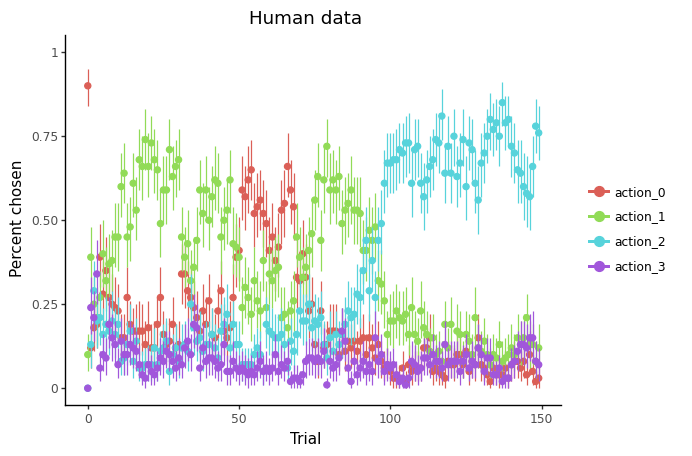

<ggplot: (8757419660045)>

In [45]:
gg_actions_over_trials + gg.labs(title='Human data')

## Exercise X: Interpret simulation

What do you see? How do the agents compare to humans? What are the most striking similarities and differences?

What do you think about using the RL agent as a model of humans? Do you have an idea (maybe thinking back about the lecture) of how to improve the situation? What should our next step be?

# Part 3: Use RL as a model for human behavior

We have now trained an RL agent to perform the task. We next want to test if humans might be using RL in a similar way to learn the task. How can we do this?

To see if humans use RL to solve the task, we "fit" the RL model to human behavior. This means that we "squeeze" and "stretch" the RL agent until it produces behavior that corresponds to the human behavior.

In this case, the "squeezing" and "stretching" consists of increasing or decreasing the values of the *free parameters* of the model, $\alpha$ and $\beta$.

How do we know if we need to increase or decrease the values? By checking how close the behavior of the model is to human behavior. The closer the model behavior matches human behavior, the better the model "fits" the human dataset. We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that *maximizes the probability* that the RL model chooses the same actions that humans have chosen.

**In other (more fancy) words, our goal is to find the values for our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed (human) behavior under the model.**

To do this, we first need to know how likey the observed behavior is under each model. Once we know, all we have to do is to maximize this likelihood.

**TASK 1**: Calculate the likelihood of the human dataset under model parameters $\alpha=0.3$ and $\beta=3$, by filling in the blanks below.

**TASK 2**: Maximize the likelihood of the human dataset by finding the optimal parameters. Fill in the blanks below.

Let's first modify our simulation function to accept an external dataset of actions and rewards that "force" the RL agent's choices on each trial.

In [46]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    # ============== FILL IN THE BLANKS BELOW ================
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    # ============== FILL IN THE BLANKS BELOW ================
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

In [47]:
human_data['reward_01'] = human_data['reward'] / 100

In [48]:
agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)
n_trials_sim = 5

simulation = fit_rl_agent(agent, human_data, batch_size=1, n_trials=n_trials_sim, verbose=True)
simulation['all_actions'], human_data['action'][:n_trials_sim], simulation['all_rewards'], human_data['reward'][:n_trials_sim]

Initial action values [[0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]]
Chosen action [[1. 0. 0. 0.]]
Obtained reward [0.84]
New action values [[0.602 0.5   0.5   0.5  ]]

Trial 1
Action probabilities [[0.31160805 0.229464   0.229464   0.229464  ]]
Chosen action [[0. 1. 0. 0.]]
Obtained reward [0.9]
New action values [[0.602 0.62  0.5   0.5  ]]

Trial 2
Action probabilities [[0.283426   0.29915178 0.2087111  0.2087111 ]]
Chosen action [[0. 0. 1. 0.]]
Obtained reward [0.53]
New action values [[0.602 0.62  0.509 0.5  ]]

Trial 3
Action probabilities [[0.2818163  0.29745275 0.21320526 0.20752575]]
Chosen action [[0. 0. 0. 1.]]
Obtained reward [0.24]
New action values [[0.602 0.62  0.509 0.422]]

Trial 4
Action probabilities [[0.29457054 0.31091467 0.22285435 0.17166047]]
Chosen action [[0. 1. 0. 0.]]
Obtained reward [0.92]
New action values [[0.602      0.71000004 0.509      0.422     ]]


(array([[0.],
        [1.],
        [2.],
        [3.],
        [1.]]),
 0    0.0
 1    1.0
 2    2.0
 3    3.0
 4    1.0
 Name: action, dtype: float64,
 array([[0.84],
        [0.9 ],
        [0.53],
        [0.24],
        [0.92]]),
 0    84.0
 1    90.0
 2    53.0
 3    24.0
 4    92.0
 Name: reward, dtype: float64)

Now, let's calculate the probabilities of each (forced!) action choice.

In [49]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_action_probs = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    # ============== FILL IN THE BLANKS BELOW ================
    all_action_probs += [action_probs]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_action_probs': np.array(all_action_probs),
    }

In [50]:
simulation = fit_rl_agent(agent, human_data, batch_size=1, n_trials=n_trials_sim, verbose=True)
all_actions_1h = np.array(jax.nn.one_hot(simulation['all_actions'], num_classes=n_bandits))

Initial action values [[0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]]
Chosen action [[1. 0. 0. 0.]]
Obtained reward [0.84]
New action values [[0.602 0.5   0.5   0.5  ]]

Trial 1
Action probabilities [[0.31160805 0.229464   0.229464   0.229464  ]]
Chosen action [[0. 1. 0. 0.]]
Obtained reward [0.9]
New action values [[0.602 0.62  0.5   0.5  ]]

Trial 2
Action probabilities [[0.283426   0.29915178 0.2087111  0.2087111 ]]
Chosen action [[0. 0. 1. 0.]]
Obtained reward [0.53]
New action values [[0.602 0.62  0.509 0.5  ]]

Trial 3
Action probabilities [[0.2818163  0.29745275 0.21320526 0.20752575]]
Chosen action [[0. 0. 0. 1.]]
Obtained reward [0.24]
New action values [[0.602 0.62  0.509 0.422]]

Trial 4
Action probabilities [[0.29457054 0.31091467 0.22285435 0.17166047]]
Chosen action [[0. 1. 0. 0.]]
Obtained reward [0.92]
New action values [[0.602      0.71000004 0.509      0.422     ]]


In [51]:
def calculate_neg_log_likelihood(agent, n_trials, batch_size):

  simulation = fit_rl_agent(agent, human_data, batch_size=batch_size, n_trials=n_trials)
  all_actions_1h = np.array(jax.nn.one_hot(simulation['all_actions'], num_classes=n_bandits))

  # ============== FILL IN THE BLANKS BELOW ================
  chosen_action_probs = np.sum(all_actions_1h * np.array(simulation['all_action_probs']), axis=-1)  # this is a list of action probabilities, with one probability per trial, showing the agent's probability of choosing the chosen action
  chosen_action_probs += 1e-5  # we add a very small number to avoids 0's, for which the log would be -inf, which would destroy our calculation
  av_neg_log_likelihood = -np.sum(np.log(chosen_action_probs)) / n_trials / batch_size  # now, we average the log-likelihoods over all participants and all trials, to get an average trial-based measure

  return av_neg_log_likelihood

# Test
calculate_neg_log_likelihood(agent, 5, 2)

1.433126449584961

In [52]:
nlls = []
n_points_sqrt = 5
batch_size = 100
n_trials = 150
min_beta = 1.
max_beta = 30.

for alpha in np.arange(n_points_sqrt) / n_points_sqrt:
  print(alpha)
  for beta in min_beta + np.arange(n_points_sqrt) / n_points_sqrt * max_beta:

    agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': alpha, 'beta': beta})
    nll = calculate_neg_log_likelihood(agent, n_trials, batch_size)

    nlls.append([alpha, beta, nll])

nlls = pd.DataFrame(nlls, columns=['alpha', 'beta', 'nll'])

0.0
0.2
0.4
0.6
0.8


**NOTE**: In reality, we would use a *function optimizer* to find the best parameters, instead of doing *grid search* like we did above.

*Grid search* means that we manually calculate results for the entire "grid" of possible solutions. In this case, we manually calculated the NLLs for each possible pair of $\alpha$ and $\beta$. We then look at the grid and find the spot with the best result, aka the smallest NLL.

*Function optimization* means that we automatize this entire process: We submit our NLL function to an optimizer that automatically finds the minimum of the function. This saves time because function optimizers are usually very fast and have smarter strategies for finding a minimum than checking everywhere.

In [53]:
best_nll = np.min(nlls['nll'])
best_model = nlls.loc[nlls['nll'] == best_nll, ['alpha', 'beta']]
best_model['marker'] = 'X'
best_model

,alpha,beta,marker
16,0.6,7.0,X


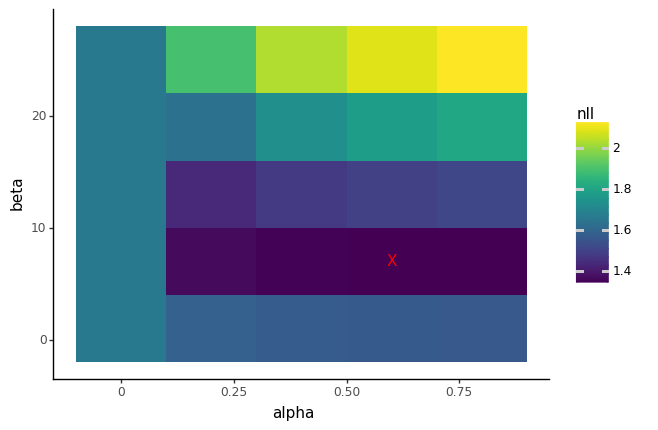

<ggplot: (8757419822273)>

In [54]:
nll_plot = (gg.ggplot(nlls, gg.aes(x='alpha', y='beta', fill='nll'))
 + gg.geom_tile()
 + gg.geom_text(best_model, gg.aes(label='marker'), color='red')
)
nll_plot

Here is a high-resolution version of this plot:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/NllGrid.png?raw=1" width=1000></center>

## Exercise 4: Interpret findings (*10 minutes*)

What do you conclude from our results? What did the "fitting" procedure reveal about human choices in this task?

## Exercise X: Simulate agents, plot, interpret

In [55]:
best_rl_parameters = {'alpha': best_model['alpha'].values[0], 'beta': best_model['beta'].values[0]}  # this line will use the parameters you have calculated
best_rl_parmaeters = {'alpha': 0.76, 'beta': 6.3999999999999995}  # here are the parameters using the same code, but a finer grain in our grid search (`n_points_sqrt = 50`)
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

In [56]:
agent = RlAgent(n_actions=n_bandits, rl_parameters=best_rl_parameters)
simulation = simulate_rl_agents(agent, n_participants, n_trials, n_bandits)
simulation['all_actions'], simulation['all_rewards']

(array([[0, 1, 2, ..., 1, 1, 1],
        [1, 0, 3, ..., 1, 1, 1],
        [2, 1, 2, ..., 1, 0, 1],
        ...,
        [2, 2, 2, ..., 1, 2, 2],
        [2, 2, 3, ..., 1, 2, 2],
        [2, 2, 2, ..., 3, 2, 3]], dtype=int32),
 array([[0.84, 0.87, 0.42, ..., 0.87, 0.87, 0.87],
        [0.9 , 0.9 , 0.18, ..., 0.9 , 0.9 , 0.9 ],
        [0.53, 0.84, 0.53, ..., 0.84, 0.8 , 0.84],
        ...,
        [0.7 , 0.7 , 0.7 , ..., 0.35, 0.7 , 0.7 ],
        [0.6 , 0.6 , 0.59, ..., 0.44, 0.6 , 0.6 ],
        [0.56, 0.56, 0.56, ..., 0.51, 0.56, 0.51]]))

In [57]:
actions_long = np.array(simulation['all_actions']).T.flatten()
rewards_long = np.array(simulation['all_rewards']).T.flatten()
rl_model_data = pd.DataFrame({'action': actions_long, 'reward': rewards_long})
rl_model_data['trial_id'] = np.tile(np.arange(n_trials), n_participants)
rl_model_data['participant_id'] = np.repeat(np.arange(n_participants), n_trials)
rl_model_data

,action,reward,trial_id,participant_id
0,0,0.84,0,0
1,1,0.90,1,0
2,2,0.53,2,0
3,1,0.81,3,0
4,0,0.86,4,0
...,...,...,...,...
14995,3,0.48,145,99
14996,3,0.57,146,99
14997,2,0.70,147,99
14998,2,0.60,148,99


In [58]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
rl_model_data[action_cols] = jax.nn.one_hot(jnp.array(rl_model_data['action']), n_bandits)
rl_model_data

,action,reward,trial_id,participant_id,action_0,action_1,action_2,action_3
0,0,0.84,0,0,1.0,0.0,0.0,0.0
1,1,0.90,1,0,0.0,1.0,0.0,0.0
2,2,0.53,2,0,0.0,0.0,1.0,0.0
3,1,0.81,3,0,0.0,1.0,0.0,0.0
4,0,0.86,4,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14995,3,0.48,145,99,0.0,0.0,0.0,1.0
14996,3,0.57,146,99,0.0,0.0,0.0,1.0
14997,2,0.70,147,99,0.0,0.0,1.0,0.0
14998,2,0.60,148,99,0.0,0.0,1.0,0.0


In [59]:
# Now, let's melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_rl_model_data = pd.melt(rl_model_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_rl_model_data

,participant_id,trial_id,variable,value
0,0,0,action_0,1.0
1,0,1,action_0,0.0
2,0,2,action_0,0.0
3,0,3,action_0,0.0
4,0,4,action_0,1.0
...,...,...,...,...
59995,99,145,action_3,1.0
59996,99,146,action_3,1.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


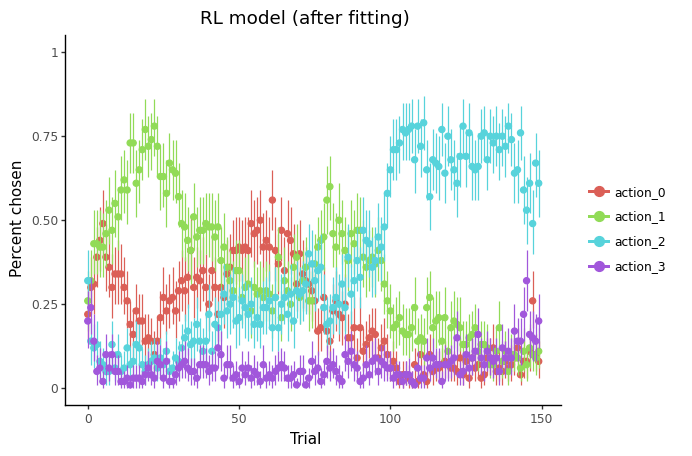

<ggplot: (8757418152939)>

In [60]:
#@title Click to show Solution 4
gg_actions_over_trials_rl_model = (gg.ggplot(long_rl_model_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
 + gg.labs(title='RL model (after fitting)')
)
gg_actions_over_trials_rl_model

In [61]:
# Plot values over time as well!
# gg_actions_over_trials_rl_agents + gg.aes(y='')

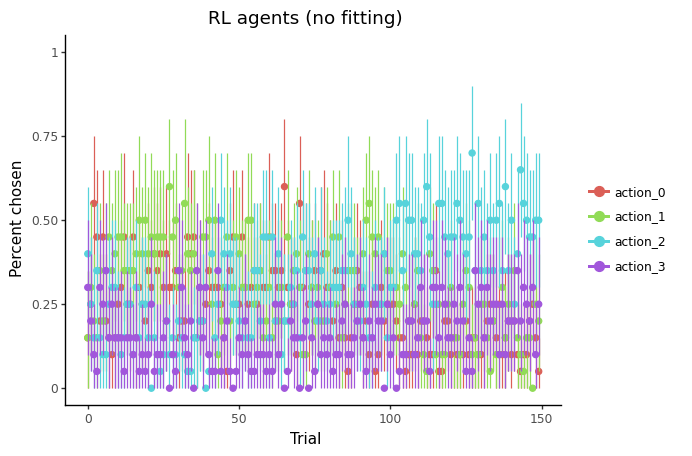

<ggplot: (8757418152372)>

In [62]:
gg_actions_over_trials_rl_agents + gg.labs(title='RL agents (no fitting)')

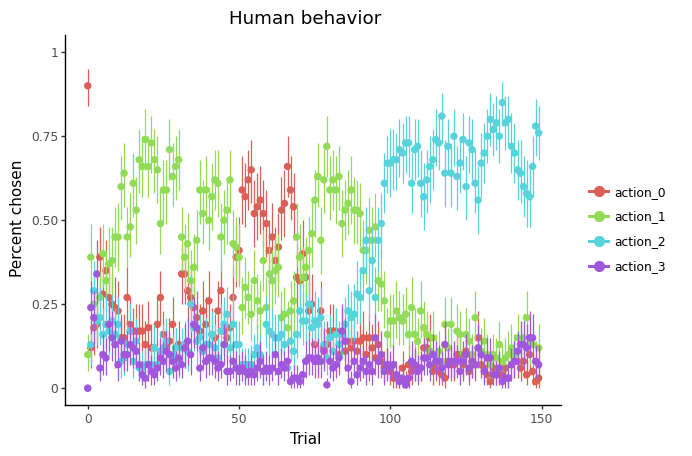

<ggplot: (8757419487611)>

In [63]:
gg_actions_over_trials + gg.labs(title='Human behavior')

## Exercise X: Interpret findings (*5 minutes*)
What do you conclude from our findings?
* How has the model fitting changed model behavior?
* What can the fitted model tell us about human behavior?

* after fitting: better congruence between human and RL model behavior
* human behavior: can be explained as an RL process -> humans might be using RL-like processes to perform this task; the brain might implement an RL-like algorithm, so there might be brain areas that perform the relevant computations (more about that later); people with difficulties learning or making decisions might suffer from brain abnormalities that we could categorize using these models.
* we can explain differences in behavior as differences in model parameters (e.g., learning rate $\alpha$, decision temperature $\beta$), or as differences of the underlying model (e.g., RL versus something else); model fitting and model comparison (see below) can answer this question
* the model also allows us to make predictions: we can feed it with new parameters, click start, and see what behavior should look like; for example, if we identify a condition that affects the learning rate, we can make prediction what behavior should look like in different scenarios, using the model

## Exercise 5: Thinking deeper (*10 minutes*)

What are the advantages and disadvantages of the model fitting method, in your opinion? What are its limitations? What could we do to go beyond these limitations?

# Part 4: Use RL as a neural model

Like we've seen in the lecture, there is lots of evidence that the brain might implent an RL algorithm: Most notably, the dopamine system has been argued to calculate reward prediction errors (RPEs), such that dopamine neurons *increase* their firing rates when there is a *positive* RPE (reward is *larger* than expected), and *decrease* their firing rates when there is a *negative* RPE (reward is *smaller* than expected).

In this section, we will see if this is the case in our dataset.

TASK 1: Calculate RPEs. For each trial in the task, calculate the RPE the model is encountering. (Make sure you save the RPEs for each trial so we can later compare them to human striatal activity.)

TASK 2: Plot the model-based RPEs against the human fMRI signal (RPEs on the y-axis and BOLD signal on the x-axis). What do you see?

TASK 3: Calcualte the correlation between model-based RPEs and striatal BOLD signal. What do you conclude about the hypothesis that the striatal dopamine systems encodes RPEs?

In [64]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  all_action_probs = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_rpes = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]

    # ============== FILL IN THE BLANKS BELOW ================
    chosen_action_value = np.sum(action_1h * agent_values, axis=-1)
    rpe = reward - chosen_action_value

    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    all_action_probs += [action_probs]
    # ============== FILL IN THE BLANKS BELOW ================
    all_rpes += [rpe]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')
      print(f'RPE {rpe}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    'all_action_probs': np.array(all_action_probs),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_rpes': np.array(all_rpes)
    }

In [65]:
rl_parameters = {'alpha': 0.3, 'beta': 3.}
agent = RlAgent(n_bandits, best_rl_parameters)

fit = fit_rl_agent(agent, human_data, batch_size=100, n_trials=150, init_value=0.5)

In [66]:
human_data['fitted_rpes'] = fit['all_rpes'].T.flatten()

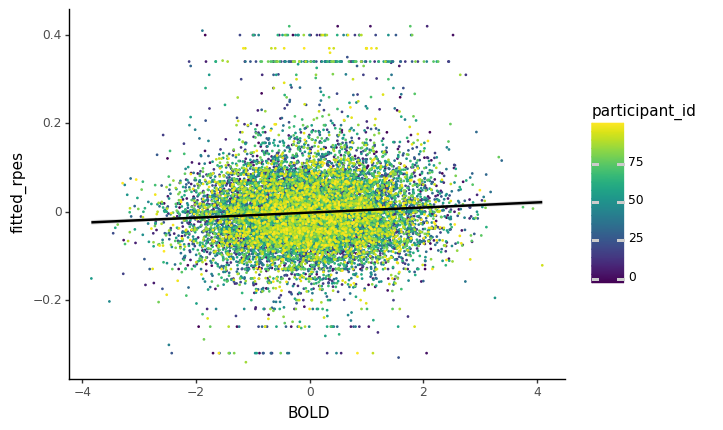

<ggplot: (8757419622806)>

In [67]:
(gg.ggplot(human_data, gg.aes('BOLD', 'fitted_rpes', color='participant_id'))
  + gg.geom_point(size=0.1)
  + gg.geom_smooth()
)

In [68]:
scipy.stats.pearsonr(human_data['BOLD'], human_data['fitted_rpes'])

PearsonRResult(statistic=0.07066456934582685, pvalue=4.526308725484682e-18)

# (*BONUS*) Speeding things up with stochastic gradient descent

In [69]:
n_training_steps = 10000

optimizer = optax.adamw(learning_rate=1e-3, weight_decay=1e-4)
init_opt = jax.jit(optimizer.init)

In [70]:
rl_parameters['fit_alpha'] = True
rl_parameters['fit_beta'] = True

In [71]:
class RlAbAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value

    if rl_parameters['fit_alpha']:
      self._alpha = jax.nn.sigmoid(  # 0 < alpha < 1
          hk.get_parameter('unsigmoid_alpha', (1,), init=jnp.zeros)
      )
    else:
      self._alpha = rl_parameters['alpha']

    if rl_parameters['fit_beta']:
      self._beta = 10 * jax.nn.relu(  # 0 < beta < inf
          hk.get_parameter('unrelued_beta_div10', (1,), init=jnp.ones)
      )
    else:
      self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  # ============== FILL IN THE BLANKS BELOW ================
  def __call__(self, inputs: jnp.array, prev_value: jnp.array):

    action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
    reward = inputs[:, -1]  # shape: (batch_size,)

    # Value update
    new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

    # Action selection probabilities
    action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

    return action_probs, new_value

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [75]:
def _rlab_agent_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = RlAbAgent(n_bandits, rl_parameters)
  batch_size = input_seq.shape[0]
  initial_values = model.initial_values(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_values,
      time_major=False,
      return_all_states=return_all_states)

In [77]:
@jax.jit
def nll_fn_rlab(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  action_probs_seq, _ = rlab_agent_fn.apply(params, key, input_seq)
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4  # make sure there are no 0 probabilities

  # calculate NLL (aka cross-entropy)
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [81]:
@jax.jit
def update_func_rlab(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_rlab)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [73]:
input_seq = human_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward_01']]
input_seq = input_seq.values.reshape([batch_size, n_trials, n_bandits + 1])
# input_seq

In [78]:
rlab_agent_fn = hk.transform(_rlab_agent_fn)
params_rlab = rlab_agent_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_rlab)
params_rlab

{'~': {'unsigmoid_alpha': Array([0.], dtype=float32),
  'unrelued_beta_div10': Array([1.], dtype=float32)}}

In [80]:
init_nll = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

Average trialwise probability of initial model to act like humans: 34.0367317199707%


In [83]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_rlab, opt_state, scalars = update_func_rlab(
      params_rlab, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_rlab(
      params_rlab, next(rng_seq), input_seq)

  if current_step % 100 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

Step 0: nll = 1.0774970054626465
Step 100: nll = 1.0582455396652222
Step 200: nll = 1.0470932722091675
Step 300: nll = 1.0416302680969238
Step 400: nll = 1.0391279458999634
Step 500: nll = 1.037920594215393
Step 600: nll = 1.037243366241455
Step 700: nll = 1.0367931127548218
Step 800: nll = 1.0364623069763184
Step 900: nll = 1.036210298538208
Step 1000: nll = 1.0360157489776611
Step 1100: nll = 1.0358648300170898
Step 1200: nll = 1.0357475280761719
Step 1300: nll = 1.0356566905975342
Step 1400: nll = 1.0355868339538574
Step 1500: nll = 1.0355327129364014
Step 1600: nll = 1.0354909896850586
Step 1700: nll = 1.0354595184326172
Step 1800: nll = 1.0354357957839966
Step 1900: nll = 1.035417914390564
Step 2000: nll = 1.0354045629501343
Step 2100: nll = 1.0353947877883911
Step 2200: nll = 1.0353877544403076
Step 2300: nll = 1.035382866859436
Step 2400: nll = 1.0353790521621704
Step 2500: nll = 1.0353765487670898
Step 2600: nll = 1.0353747606277466
Step 2700: nll = 1.0353736877441406
Step 2800

In [84]:
final_nll = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

Average trialwise probability of initial model to act like humans: 35.5094313621521%


In [87]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

all_scalars['alpha'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_alpha']))
all_scalars['beta_div10'] = jax.nn.relu(jnp.array(all_scalars['unrelued_beta_div10']))

best_rlab = all_scalars.iloc[-1]

all_scalars

,nll,unrelued_beta_div10,unsigmoid_alpha,step,alpha,beta_div10
0,1.077730,1.000000,0.000000,0.0,0.500000,1.000000
1,1.058396,0.904852,-0.088582,100.0,0.477869,0.904852
2,1.047172,0.825885,-0.130340,200.0,0.467461,0.825885
3,1.041667,0.766172,-0.101890,300.0,0.474550,0.766172
4,1.039145,0.725070,-0.014853,400.0,0.496287,0.725070
...,...,...,...,...,...,...
95,1.035372,0.648526,1.114582,9500.0,0.752982,0.648526
96,1.035372,0.648526,1.114583,9600.0,0.752982,0.648526
97,1.035372,0.648526,1.114583,9700.0,0.752982,0.648526
98,1.035372,0.648526,1.114583,9800.0,0.752982,0.648526


In [86]:
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

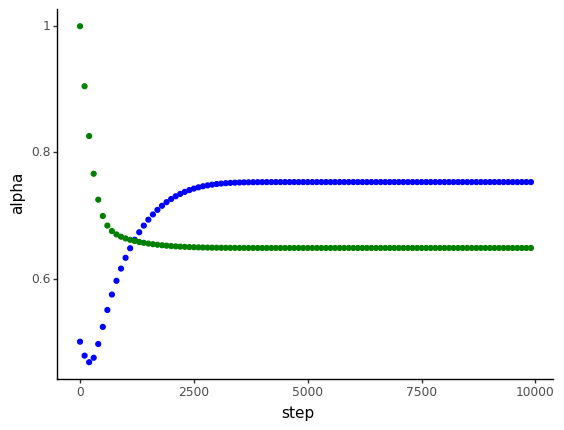

<ggplot: (8757399995663)>

In [88]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='alpha'), color='blue')
 + gg.geom_point(gg.aes(y='beta_div10'), color='green')
)

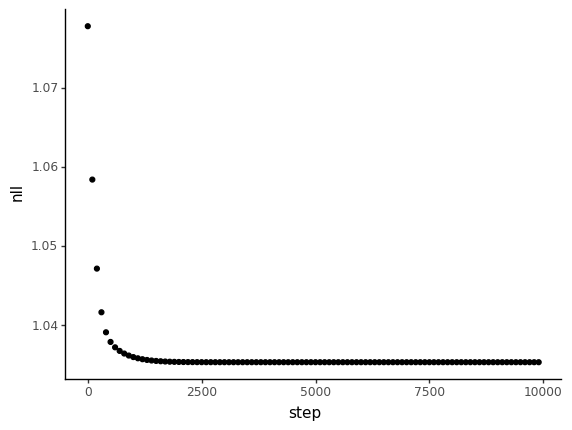

<ggplot: (8757419698750)>

In [89]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

# (*BONUS*) Improve the model; add forgetting as a cognitive process

In [145]:
# class RlAbfAgent():
#   """Define classic alpha-beta RL model."""

#   def __init__(self, n_actions, rl_parameters, init_value=0.5):

#     self._n_actions = n_actions
#     self._init_value = init_value

#     if rl_parameters['fit_alpha']:
#       self._alpha = jax.nn.sigmoid(  # 0 < alpha < 1
#           hk.get_parameter('unsigmoid_alpha', (1,), init=jnp.zeros)
#       )
#     else:
#       self._alpha = rl_parameters['alpha']

#     if rl_parameters['fit_beta']:
#       self._beta = 10 * jax.nn.relu(  # 0 < beta < inf
#           hk.get_parameter('unrelued_beta_div10', (1,), init=jnp.ones)
#       )
#     else:
#       self._beta = rl_parameters['beta']

#     # ============== FILL IN THE BLANKS BELOW ================
#     if rl_parameters['fit_forget']:
#       self._forget = jax.nn.sigmoid(  # 0 < forget < 1
#           hk.get_parameter('unsigmoid_forget', (1,), init=jnp.zeros)
#       )
#     else:
#       self._forget = rl_parameters['forget']

#   def update_values(self, value, action, reward):
#     """SARSA value update."""
#     rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
#     new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

#     return new_value

#   def calculate_action_probs(self, value):
#     return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

#   def choose_action(self, action_probs):
#     return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

#   def __call__(self, inputs: jnp.array, prev_value: jnp.array):
#     action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
#     reward = inputs[:, -1]  # shape: (batch_size,)

#     # Value update
#     new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

#     # Value forgetting
#     # ============== FILL IN THE BLANKS BELOW ================
#     new_value = (1 - self._forget) * new_value + self._forget * self._init_value

#     # Action selection probabilities
#     action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

#     return action_probs, new_value

#   def initial_values(self, batch_size):
#     return self._init_value * jnp.ones([batch_size, self._n_actions])

In [146]:
rl_parameters['fit_forget'] = True
rl_parameters['forget'] = 0.

In [148]:
class RlAbfAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value

    if rl_parameters['fit_alpha']:
      self._alpha = jax.nn.sigmoid(  # 0 < alpha < 1
          hk.get_parameter('unsigmoid_alpha', (1,), init=jnp.zeros)
      )
    else:
      self._alpha = rl_parameters['alpha']

    if rl_parameters['fit_beta']:
      self._beta = 10 * jax.nn.relu(  # 0 < beta < inf
          hk.get_parameter('unrelued_beta_div10', (1,), init=jnp.ones)
      )
    else:
      self._beta = rl_parameters['beta']

    # ============== FILL IN THE BLANKS BELOW ================
    if rl_parameters['fit_forget']:
      self._forget = jax.nn.sigmoid(  # 0 < forget < 1
          hk.get_parameter('unsigmoid_forget', (1,), init=jnp.zeros)
      )
    else:
      self._forget = rl_parameters['forget']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  # ============== FILL IN THE BLANKS BELOW ================
  def __call__(self, inputs: jnp.array, prev_value: jnp.array):

    action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
    reward = inputs[:, -1]  # shape: (batch_size,)

    # Value update
    new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

    # Value forgetting
    # ============== FILL IN THE BLANKS BELOW ================
    new_value = (1 - self._forget) * new_value + self._forget * self._init_value

    # Action selection probabilities
    action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

    return action_probs, new_value

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [149]:
def _rlabf_agent_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = RlAbfAgent(n_bandits, rl_parameters)
  batch_size = input_seq.shape[0]
  initial_values = model.initial_values(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_values,
      time_major=False,
      return_all_states=return_all_states)

In [150]:
@jax.jit
def nll_fn_rlabf(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  action_probs_seq, _ = rlabf_agent_fn.apply(params, key, input_seq)
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4  # make sure there are no 0 probabilities

  # calculate NLL (aka cross-entropy)
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [151]:
@jax.jit
def update_func_rlabf(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_rlabf)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [152]:
input_seq = human_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward_01']]
input_seq = input_seq.values.reshape([batch_size, n_trials, n_bandits + 1])
# input_seq

In [153]:
rlabf_agent_fn = hk.transform(_rlabf_agent_fn)
params_rlabf = rlabf_agent_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_rlabf)
params_rlabf

{'~': {'unsigmoid_alpha': Array([0.], dtype=float32),
  'unrelued_beta_div10': Array([1.], dtype=float32),
  'unsigmoid_forget': Array([0.], dtype=float32)}}

In [154]:
init_nll = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

Average trialwise probability of initial model to act like humans: 31.04686439037323%


In [155]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_rlabf, opt_state, scalars = update_func_rlabf(
      params_rlabf, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_rlabf(
      params_rlabf, next(rng_seq), input_seq)

  if current_step % 1000 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

Step 0: nll = 1.169394850730896
Step 100: nll = 1.1414833068847656
Step 200: nll = 1.1144908666610718
Step 300: nll = 1.090335488319397
Step 400: nll = 1.0704487562179565
Step 500: nll = 1.0553982257843018
Step 600: nll = 1.0448873043060303
Step 700: nll = 1.038051962852478
Step 800: nll = 1.0338361263275146
Step 900: nll = 1.0312786102294922
Step 1000: nll = 1.0296541452407837
Step 1100: nll = 1.0284885168075562
Step 1200: nll = 1.027511477470398
Step 1300: nll = 1.0265878438949585
Step 1400: nll = 1.0256577730178833
Step 1500: nll = 1.0247018337249756
Step 1600: nll = 1.023715615272522
Step 1700: nll = 1.0227024555206299
Step 1800: nll = 1.0216681957244873
Step 1900: nll = 1.0206193923950195
Step 2000: nll = 1.0195626020431519
Step 2100: nll = 1.0185047388076782
Step 2200: nll = 1.0174528360366821
Step 2300: nll = 1.0164132118225098
Step 2400: nll = 1.0153920650482178
Step 2500: nll = 1.0143948793411255
Step 2600: nll = 1.0134267807006836
Step 2700: nll = 1.0124915838241577
Step 2800

KeyboardInterrupt: ignored

In [156]:
final_nll = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

Average trialwise probability of initial model to act like humans: 36.91794276237488%


In [157]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

all_scalars['alpha'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_alpha']))
all_scalars['forget'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_forget']))
all_scalars['beta_div10'] = jax.nn.relu(jnp.array(all_scalars['unrelued_beta_div10']))

best_rlabf = all_scalars.iloc[-1]

all_scalars

,nll,unrelued_beta_div10,unsigmoid_alpha,unsigmoid_forget,step,alpha,beta_div10
0,1.169672,1.000000,0.000000,0.000000,0.0,0.500000,1.000000
1,1.141761,1.099698,0.099590,-0.100821,100.0,0.524877,1.099698
2,1.114750,1.197232,0.195934,-0.202231,200.0,0.548827,1.197232
3,1.090558,1.290009,0.285185,-0.301094,300.0,0.570817,1.290009
4,1.070624,1.375468,0.363728,-0.394381,400.0,0.589943,1.375468
...,...,...,...,...,...,...,...
1005,0.996473,83.866722,-5.512940,-1.467740,100500.0,0.004018,83.866722
1006,0.996473,83.954491,-5.514037,-1.467701,100600.0,0.004014,83.954491
1007,0.996472,84.042404,-5.515063,-1.467710,100700.0,0.004010,84.042404
1008,0.996472,84.130379,-5.516101,-1.467704,100800.0,0.004005,84.130379


In [158]:
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

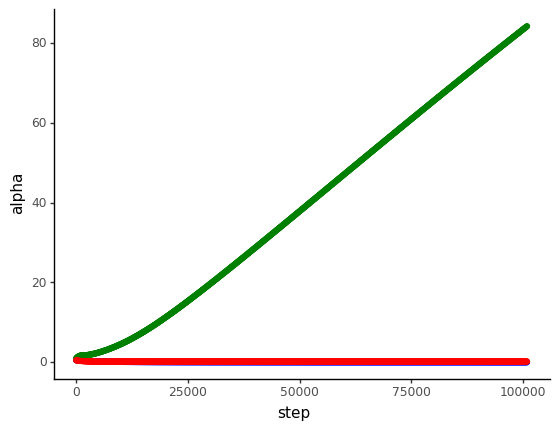

<ggplot: (8757418687101)>

In [161]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='alpha'), color='blue')
 + gg.geom_point(gg.aes(y='beta_div10'), color='green')
 + gg.geom_point(gg.aes(y='forget'), color='red')
)

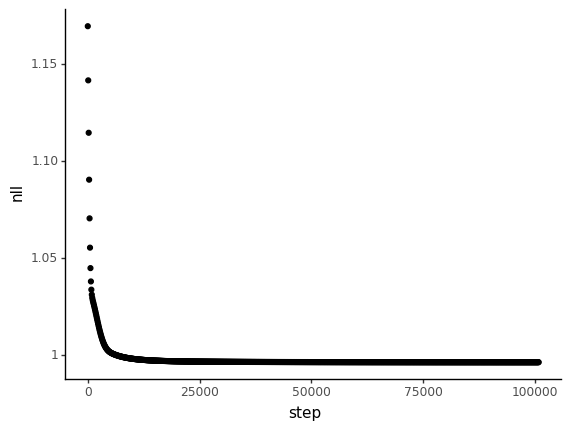

<ggplot: (8757419305357)>

In [162]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

In [166]:
aic_rlab = 2 * best_rlab['nll'] * n_trials + 2 * 2
aic_rlabf = 2 * best_rlabf['nll'] * n_trials + 2 * 3

print(f'AIC for rlab: {aic_rlab}')
print(f'AIC for rlabf: {aic_rlabf}')

AIC for rlab: 314.61153411865234
AIC for rlabf: 304.9418148994446


# (*Bonus*): Fit a neural network to human behavior

In [ ]:
class LstmAgent(hk.RNNCore):
  """LSTM that predicts action logits based on all inputs (action, reward)."""

  def __init__(self, n_hiddens, n_bandits):

    super().__init__()

    self._hidden_size = n_hiddens
    self._n_actions = n_bandits

  def __call__(self, inputs: jnp.array, prev_state):

    hidden_state, cell_state = prev_state

    forget_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    input_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    candidates = jax.nn.tanh(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    next_cell_state = forget_gate * cell_state + input_gate * candidates

    output_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )
    next_hidden_state = output_gate * jax.nn.tanh(next_cell_state)

    action_probs = jax.nn.softmax(
        hk.Linear(self._n_actions)(next_hidden_state))  # (batch_size, n_act)

    return action_probs, (next_hidden_state, next_cell_state)

  def initial_state(self, batch_size):

    return (jnp.zeros((batch_size, self._hidden_size)),  # hidden_state
            jnp.zeros((batch_size, self._hidden_size)))  # cell_state

In [ ]:
def _lstm_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = LstmAgent(n_hiddens=5, n_bandits=n_bandits)

  batch_size = input_seq.shape[0]
  initial_state = model.initial_state(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_state,
      time_major=False,
      return_all_states=return_all_states)

In [ ]:
@jax.jit
def nll_fn_lstm(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  # input_seq = jnp.concatenate([action_seq, reward_seq], axis=-1)
  action_probs_seq, _ = lstm_fn.apply(params, key, input_seq)
  # make sure there are no 0 probabilities
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4

  # calculate loss (NLL aka cross-entropy)
  # "sum" and not "mean" so that missed trials don't influence the results
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [ ]:
@jax.jit
def update_func(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_lstm)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [ ]:
lstm_fn = hk.transform(_lstm_fn)
params_lstm = lstm_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_lstm)
params_lstm

In [ ]:
init_nll = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

In [ ]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_lstm, opt_state, scalars = update_func(
      params_lstm, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_lstm(
      params_lstm, next(rng_seq), input_seq)

  if current_step % 100 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

In [ ]:
final_nll = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

In [ ]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

best_lstm = all_scalars.iloc[-1]

all_scalars

In [ ]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

Problem: We can't calculate AIC here -> need to do test data.

In [ ]:
# # # Option 1
# test_data = pd.read_csv("./bahrami_200.csv")

# Option 2 (in case option 1 doesn't work)
from google.colab import files
import io
uploaded = files.upload()
test_data = pd.read_csv(io.BytesIO(uploaded['bahrami_200.csv']))

test_data

In [ ]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
test_data[action_cols] = jax.nn.one_hot(jnp.array(test_data['action']), n_bandits)
test_data

In [ ]:
input_seq_test = test_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward']]
input_seq_test['reward'] /= 100
input_seq_test = input_seq_test.values.reshape([batch_size, n_trials, n_bandits + 1])
input_seq_test

In [ ]:
train_nll_rlab = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
train_nll_rlabf = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
train_nll_lstm = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)

print(f'RLab prediction accuracy on training data: {100 * np.exp(-train_nll_rlab)}%')
print(f'RLabf prediction accuracy on training data: {100 * np.exp(-train_nll_rlabf)}%')
print(f'LSTM prediction accuracy on training data: {100 * np.exp(-train_nll_lstm)}%')

test_nll_rlab = nll_fn_rlab(params_rlab, next(rng_seq), input_seq_test)
test_nll_rlabf = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq_test)
test_nll_lstm = nll_fn_lstm(params_lstm, next(rng_seq), input_seq_test)

print(f'\nRLab prediction accuracy on held-out data: {100 * np.exp(-test_nll_rlab)}%')
print(f'RLabf prediction accuracy on held-out data: {100 * np.exp(-test_nll_rlabf)}%')
print(f'LSTM prediction accuracy on held-out data: {100 * np.exp(-test_nll_lstm)}%')